# Configuration

In [1]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from data.preprocessing import load_raw_data, preprocess_datasets
from training.train import run_model_comparison
from training.summary import create_summary_table, generate_conclusions
from analysis.performance import plot_training_history, plot_performance_comparison
from analysis.bias import analyze_bias, plot_target_group_performance
from analysis.errors import analyze_errors
from analysis.efficiency import analyze_efficiency
from utils.helpers import set_seed, save_results
from visualization.plots import (
    plot_class_distribution, 
    plot_text_length_distribution, 
    plot_target_group_distribution_by_class
)
from analysis.bias import plot_gmb_metrics

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...


In [2]:
from config import (
    DATASET_PATH, BATCH_SIZE, EPOCHS, RANDOM_SEED, MODELS
)

# Set the random seed for reproducibility
set_seed(42)

# Load and Preprocess Data

In [3]:
# This will efficiently preprocess data only once
data_3class, data_2class = preprocess_datasets(DATASET_PATH)

print(f"3-class dataset shape: {data_3class.shape}")
print(f"2-class dataset shape: {data_2class.shape}")

Loading raw data...
Processing and preprocessing entries...


Processing entries: 100%|██████████| 20148/20148 [03:44<00:00, 89.77entry/s] 


Initial data: 20148
Uncertain data: 919
Total processed entries: 19229
Creating 3-class dataset...
Creating 2-class dataset...
3-class dataset shape: (19229, 5)
2-class dataset shape: (19229, 5)


# EDA

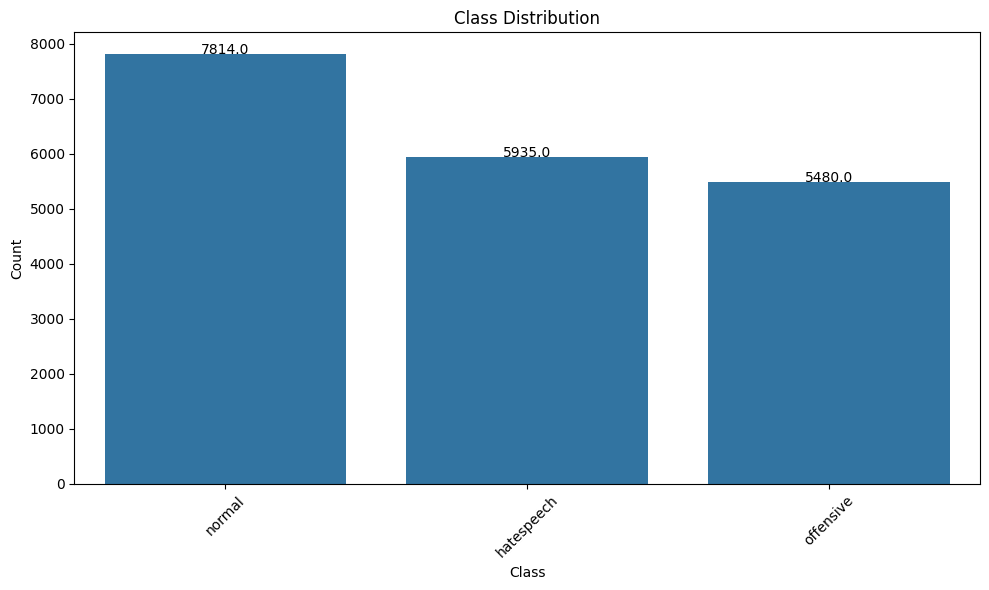

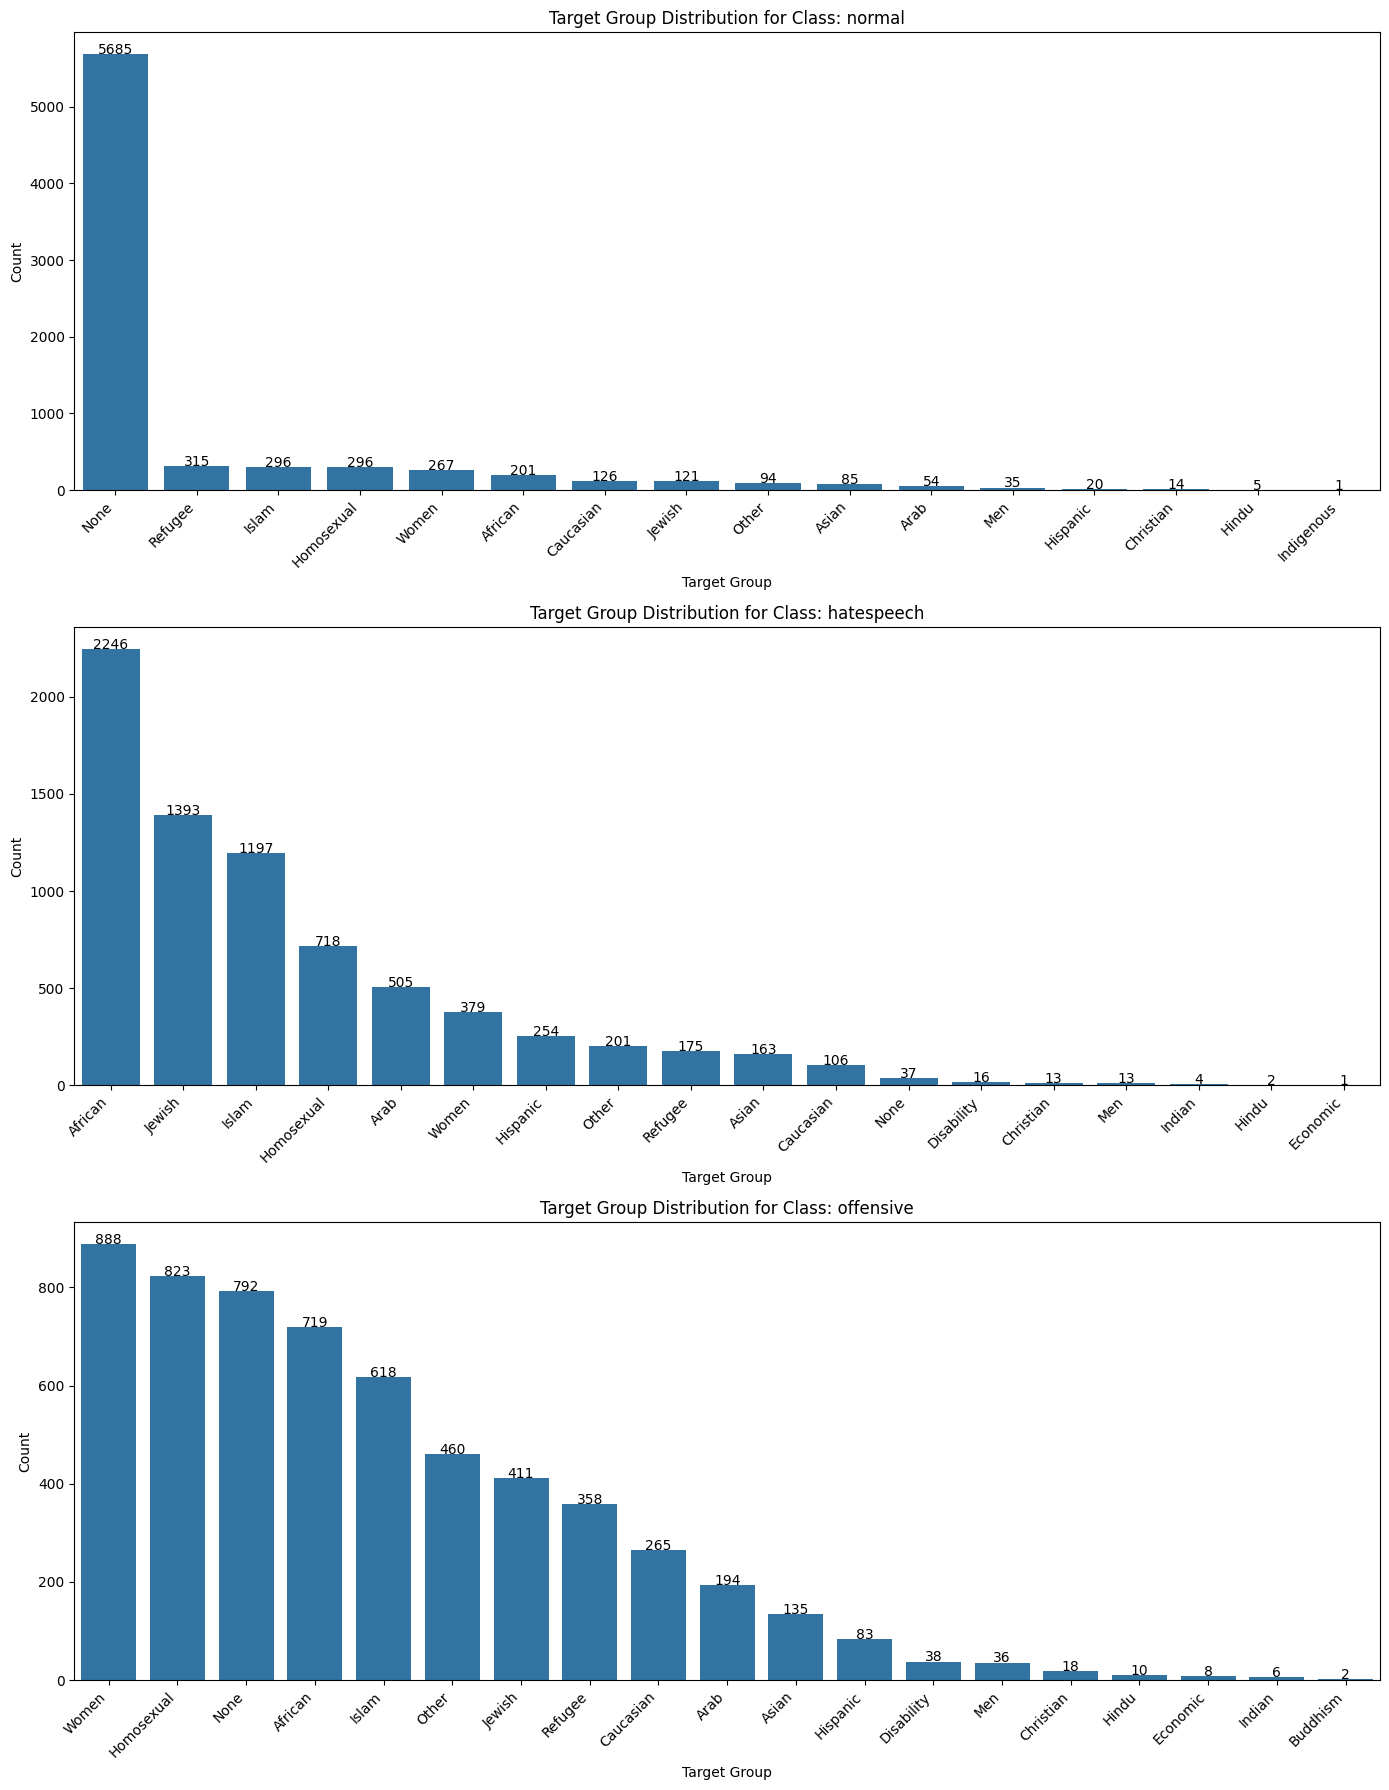

In [4]:
plot_class_distribution(data_3class)
plot_target_group_distribution_by_class(data_3class)

Target variable is not balanced, hence we modify the CrossEntropy loss function to account for the imbalance by using the class weights.

# Training

In [5]:
models_to_compare = MODELS
print("Running model comparison...")
comparison_results = run_model_comparison(
    models_to_compare,
    data_3class,
    data_2class,
    batch_size=16,
    epochs=5,
    auto_weighted=True,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.2,
    classifier_dropout=0.3,
    custom_classifier_head=True,
    weight_decay=0.1,
    patience=2,
    min_delta=0.001,
    monitor='val_loss',
)

Running model comparison...

=== Running 3-Class Classification Models ===


Training bert-base-uncased for 3-class classification
Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: np.float64(0.82029809869911), 0: np.float64(1.0800221898620068), 2: np.float64(1.169557708192536)}
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using custom classifier head for model: bert-base-uncased

Epoch 1/5


Training:   9%|▊         | 84/974 [00:41<07:24,  2.00batch/s, loss=1.04] 


KeyboardInterrupt: 

In [ ]:
# Analyze results
print("\nAnalyzing results...")

# Create summary table
summary_table = create_summary_table(comparison_results)
print("\nModel Comparison Summary:")
pd.set_option('display.precision', 4)
print(summary_table)



Analyzing results...

Model Comparison Summary:
                     Model    Task  Accuracy  F1 Score  Precision  Recall  \
9          deberta-v3-base  3class    0.7155    0.7033     0.7024  0.7057   
5        bert-base-uncased  3class    0.6973    0.6887     0.6883  0.6892   
6  distilbert-base-uncased  3class    0.6911    0.6875     0.6882  0.6898   
8         xlnet-base-cased  3class    0.6875    0.6834     0.6852  0.6876   
7             roberta-base  3class    0.6927    0.6733     0.6773  0.6819   
0        bert-base-uncased  binary    0.7941    0.7865     0.7866  0.7863   
2             roberta-base  binary    0.7785    0.7753     0.7746  0.7839   
1  distilbert-base-uncased  binary    0.7764    0.7732     0.7725  0.7818   
4          deberta-v3-base  binary    0.7769    0.7713     0.7694  0.7749   
3         xlnet-base-cased  binary    0.7665    0.7592     0.7581  0.7607   

    AUROC  
9  0.8667  
5  0.8582  
6  0.8577  
8  0.8557  
7  0.8536  
0  0.8813  
2  0.8695  
1  0.86

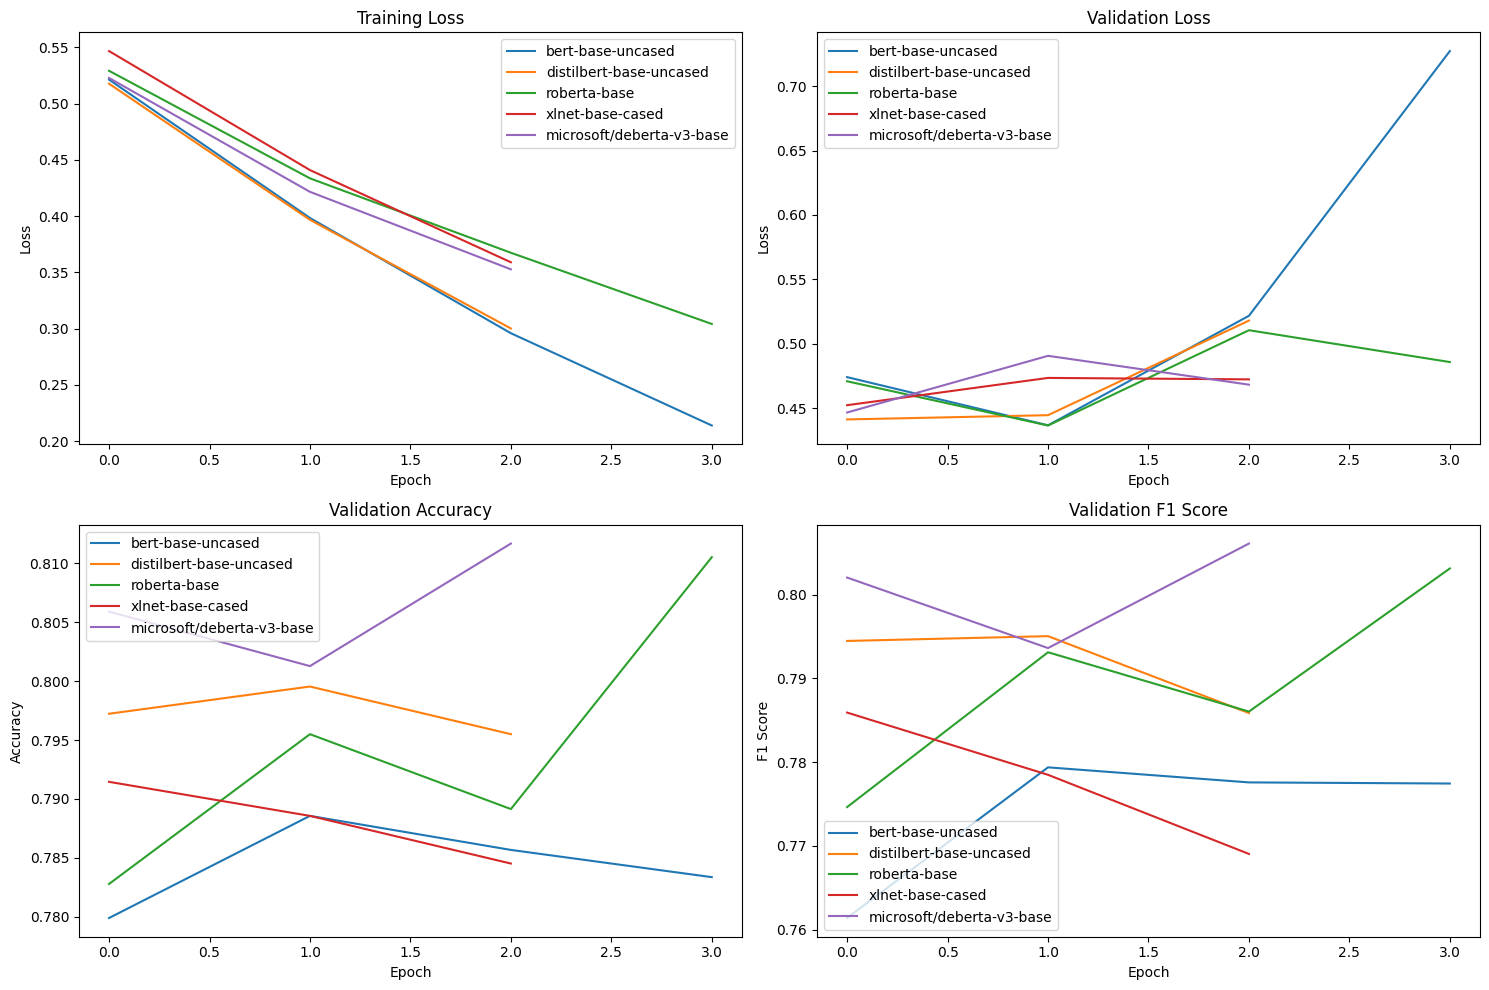

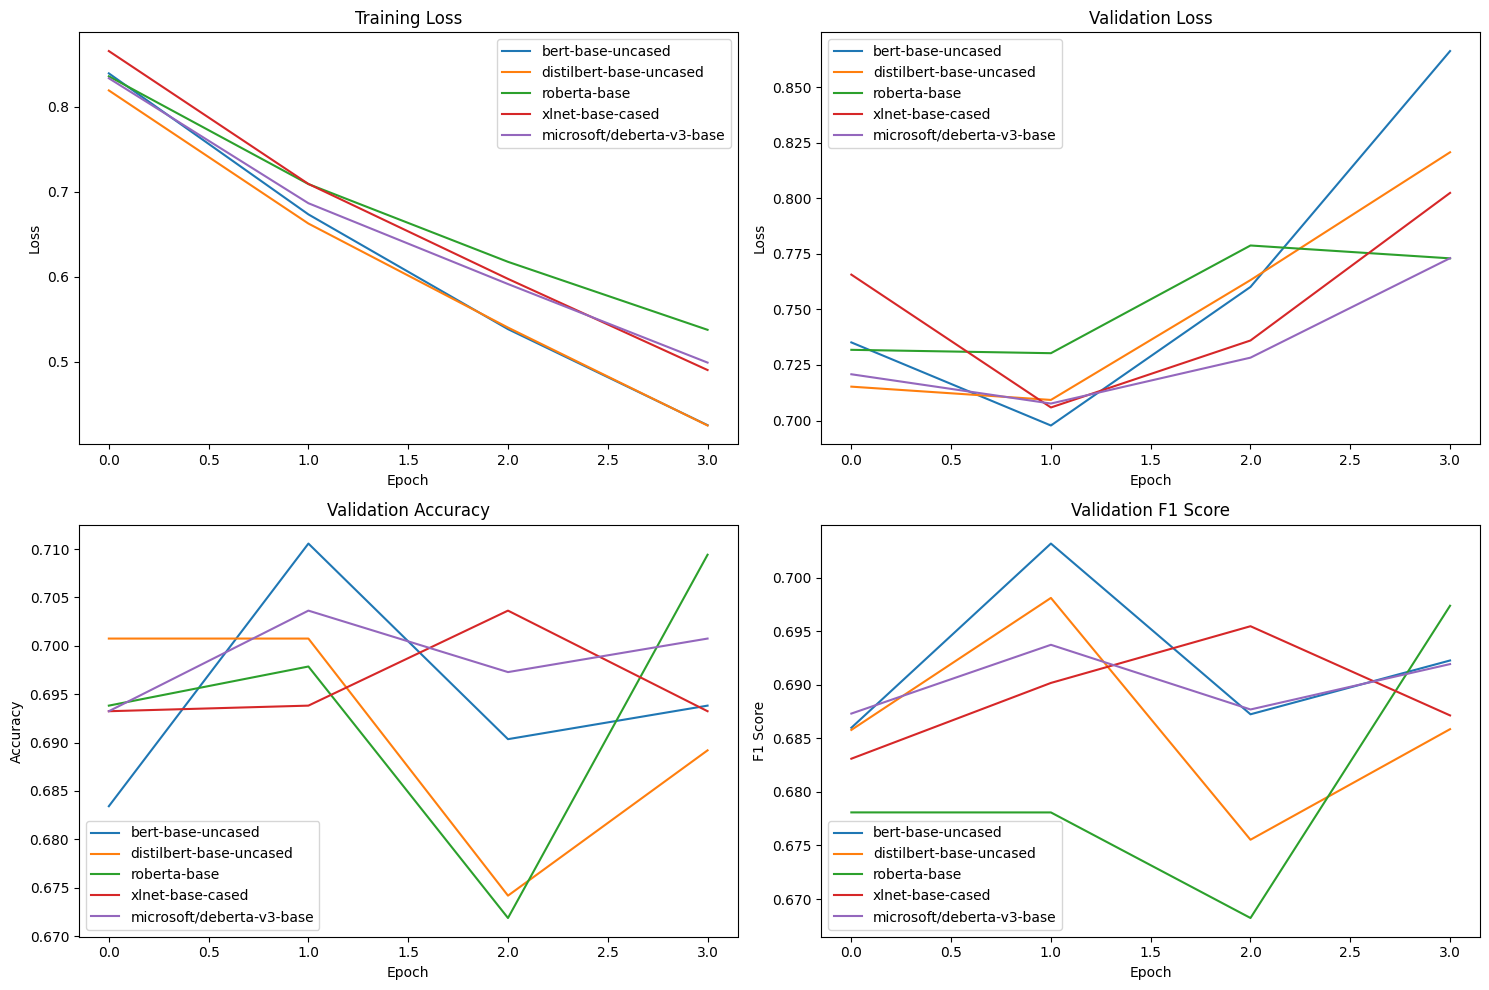

In [ ]:
# Plot training history
plot_training_history(comparison_results, task_type='binary')
plot_training_history(comparison_results, task_type='3class')

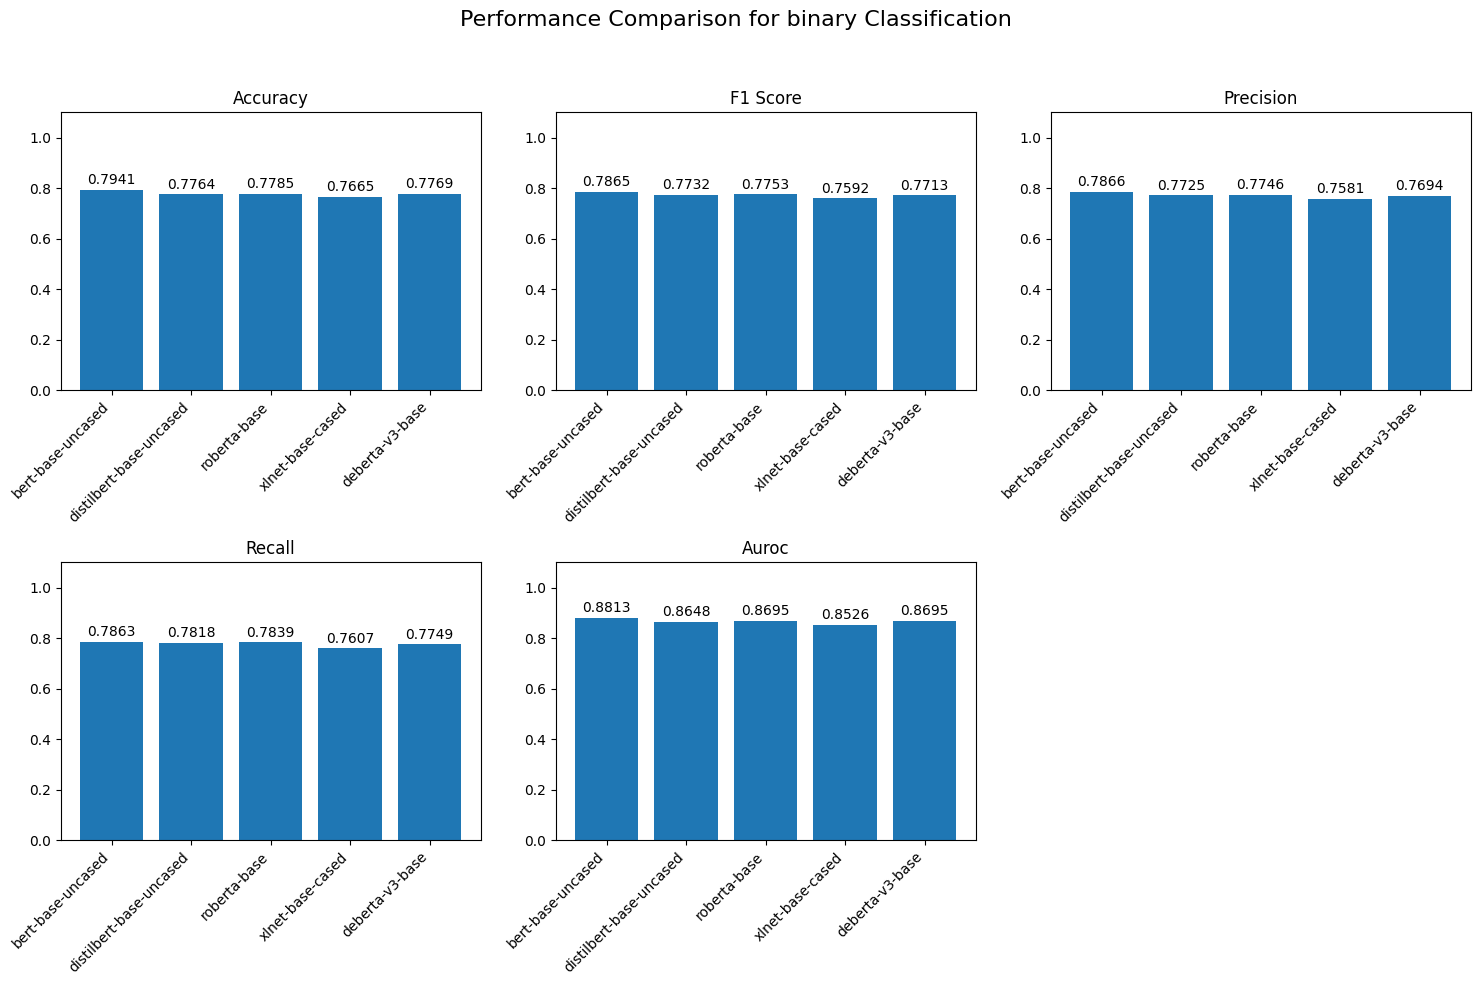

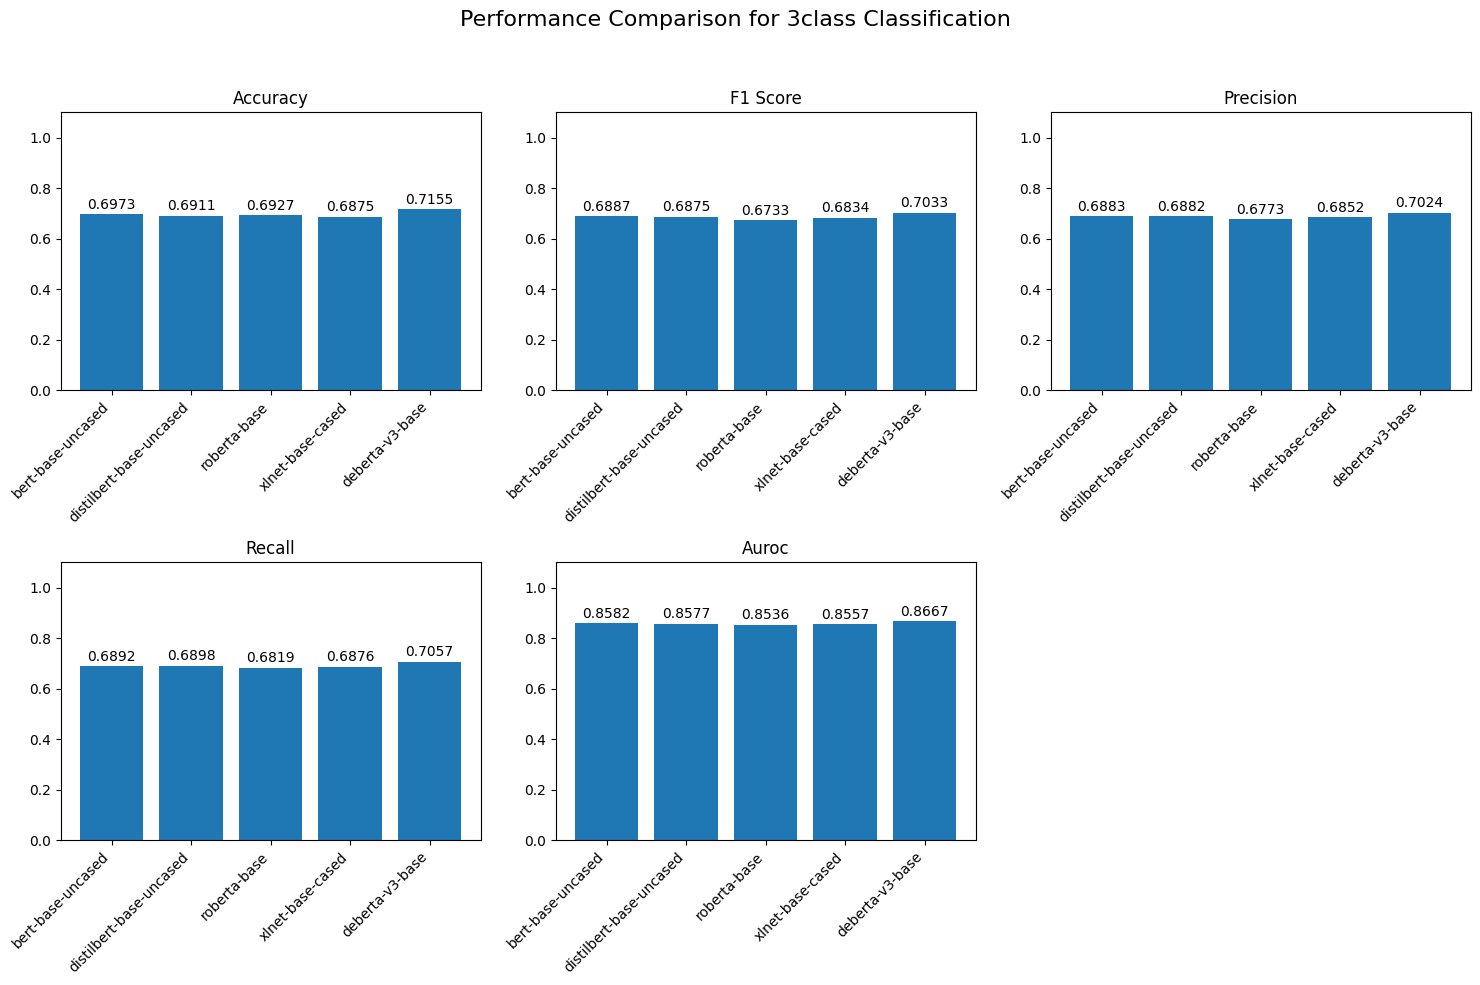

In [ ]:
# Plot performance comparison
plot_performance_comparison(comparison_results)

In [ ]:
# Analyze bias
analyze_bias(comparison_results, task_type='binary')
analyze_bias(comparison_results, task_type='3class')


=== Bias Analysis for binary Classification ===


Model: bert-base-uncased
Performance across target groups:
Mean accuracy: 0.8716
Standard deviation: 0.0784
Min accuracy: 0.7449
Max accuracy: 0.9672
Max-Min difference: 0.2222
Target group with worst performance: Refugee (accuracy: 0.7449)
Target group with best performance: Hispanic (accuracy: 0.9672)

GMB Metrics:
GMB-SUBGROUP-AUC: 0.8249
GMB-BPSN-AUC: 0.8034
GMB-BNSP-AUC: 0.8486
GMB-COMBINED-AUC: 0.8244

Model: distilbert-base-uncased
Performance across target groups:
Mean accuracy: 0.8532
Standard deviation: 0.0946
Min accuracy: 0.6502
Max accuracy: 0.9601
Max-Min difference: 0.3099
Target group with worst performance: Caucasian (accuracy: 0.6502)
Target group with best performance: Hispanic (accuracy: 0.9601)

GMB Metrics:
GMB-SUBGROUP-AUC: 0.8063
GMB-BPSN-AUC: 0.7469
GMB-BNSP-AUC: 0.8142
GMB-COMBINED-AUC: 0.7855

Model: roberta-base
Performance across target groups:
Mean accuracy: 0.8601
Standard deviation: 0.0785
Min accuracy: 

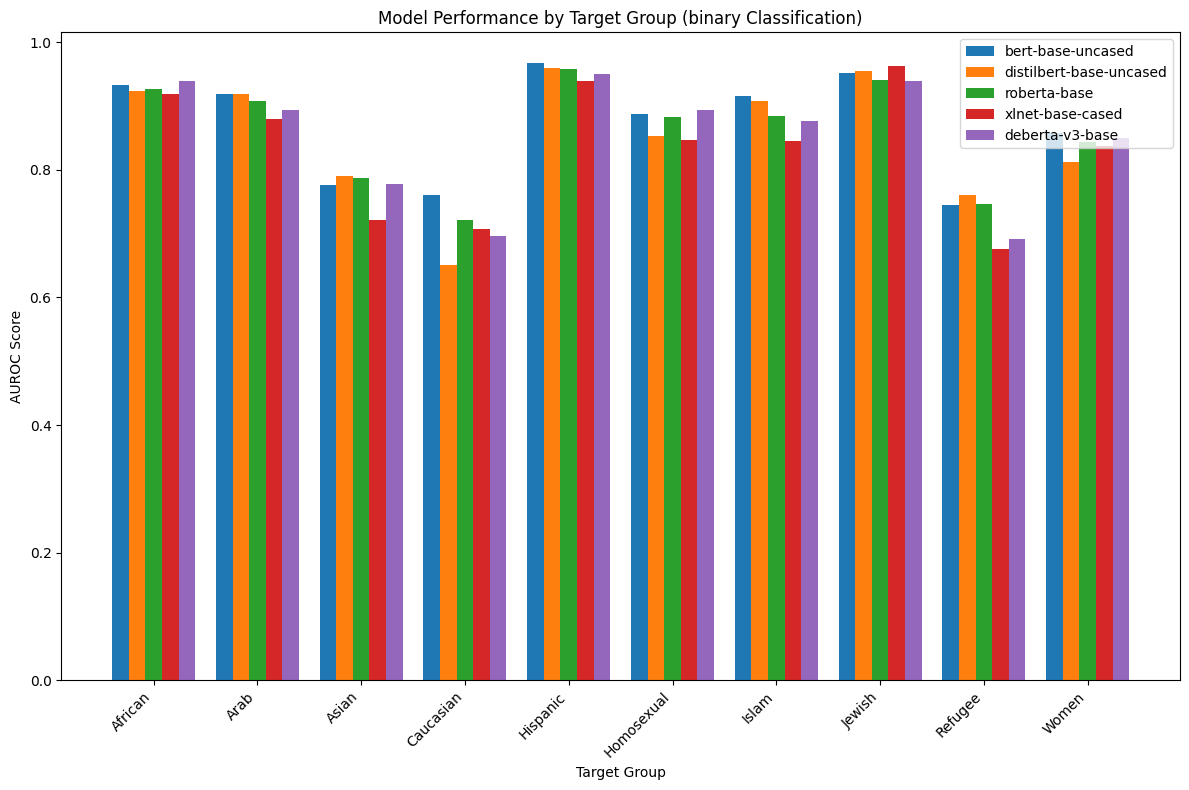

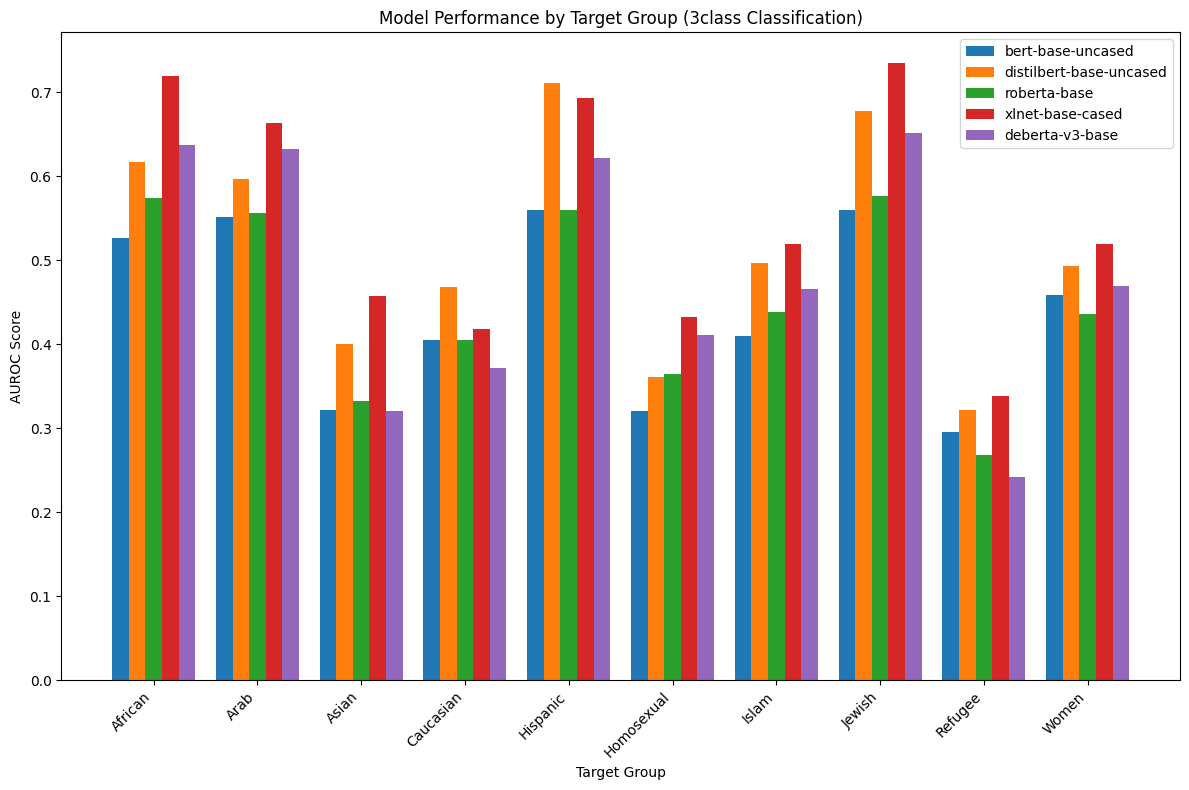

In [ ]:
# Plot target group performance
plot_target_group_performance(comparison_results, task_type='binary')
plot_target_group_performance(comparison_results, task_type='3class')

In [ ]:
# Analyze errors for best models
binary_best_model = summary_table[summary_table['Task'] == 'binary'].sort_values('F1 Score', ascending=False).iloc[0]['Model']
multiclass_best_model = summary_table[summary_table['Task'] == '3class'].sort_values('F1 Score', ascending=False).iloc[0]['Model']

# Get the full model name for analysis
for model_name in models_to_compare:
    if model_name.split('/')[-1] == binary_best_model:
        binary_best_model_full = model_name
    if model_name.split('/')[-1] == multiclass_best_model:
        multiclass_best_model_full = model_name

In [ ]:
# Error analysis
analyze_errors(
    comparison_results, 
    data_2class, 
    task_type='binary',
    model_name=binary_best_model_full
)

analyze_errors(
    comparison_results, 
    data_3class, 
    task_type='3class',
    model_name=multiclass_best_model_full
)




=== Error Analysis for bert-base-uncased on binary Classification ===

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at saved_models/bert-base-uncased_binary were not used when initializing BertForSequenceClassification: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassif

Model loaded from saved_models/bert-base-uncased_binary


Predicting: 100%|██████████| 121/121 [00:07<00:00, 17.01batch/s]


High-confidence errors (model was confident but wrong):

Example 1:
Text: <user> happy birthday muzzy thanks for being you 😊
True label: non-toxic
Predicted label: toxic
Confidence: 0.8022
Target groups: None

Example 2:
Text: <user> truly the ghetto
True label: non-toxic
Predicted label: toxic
Confidence: 0.7963
Target groups: None

Example 3:
Text: <user> kill yourself lol
True label: non-toxic
Predicted label: toxic
Confidence: 0.7932
Target groups: None

Example 4:
Text: disregard women and acquire currency
True label: non-toxic
Predicted label: toxic
Confidence: 0.7928
Target groups: None

Example 5:
Text: putin syria has been liberated time for refugees to return
True label: non-toxic
Predicted label: toxic
Confidence: 0.7928
Target groups: Refugee

Example 6:
Text: <user> when you been eating too many nazi cakes
True label: non-toxic
Predicted label: toxic
Confidence: 0.7914

Example 7:
Text: <user> not newark that ’ ghetto
True label: non-toxic
Predicted label: toxic
Confidence

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at saved_models/microsoft_deberta-v3-base_3class were not used when initializing DebertaV2ForSequenceClassification: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (

Model loaded from saved_models/microsoft_deberta-v3-base_3class


Predicting: 100%|██████████| 121/121 [00:09<00:00, 12.30batch/s]


High-confidence errors (model was confident but wrong):

Example 1:
Text: <user> why tf you stalking my shit liking tweets from over a month ago do you need something or are you just like that cloutsurfin faggot hoping you will get attention from bad bitches 👀
True label: offensive
Predicted label: normal
Confidence: 0.5694
Target groups: Homosexual

Example 2:
Text: <user> stupid fkn retard
True label: offensive
Predicted label: normal
Confidence: 0.5668
Target groups: None

Example 3:
Text: <user> lol ur an idiot fool i swear all ppl do is switch around my words hating ass faggots
True label: offensive
Predicted label: normal
Confidence: 0.5661

Example 4:
Text: what does fashbrain mean you just say words without knowing what they mean stupid people are funny keep saying stupid things retarded person you are making me laugh
True label: offensive
Predicted label: normal
Confidence: 0.5650
Target groups: None

Example 5:
Text: vader calls the for hire antifa losers globalist mask weari

,post_id,text,processed_text,target_groups,final_label,predicted,true,correct,prob_hatespeech,prob_normal,prob_offensive,confidence
19140,9600971_gab,to be fair muslims turning western women into ...,to be fair muslims turning western women into ...,"[Women, Arab, Islam]",offensive,normal,offensive,False,0.3921,0.4224,0.1855,0.4224
7806,1179047042242535425_twitter,if the jury is fucked up over that white whore...,if the jury is fucked up over that white whore...,"[Disability, Women]",offensive,normal,offensive,False,0.1982,0.5363,0.2654,0.5363
11062,1116284284602474496_twitter,<user> <user> warren you look like a democrati...,warren you look like a democratic cuck who wor...,[Men],offensive,normal,offensive,False,0.1822,0.5517,0.2660,0.5517
3589,10394634_gab,yeah because the suck is making too much money...,yeah because the suck is making too much money...,[Arab],offensive,normal,offensive,False,0.3904,0.4086,0.2011,0.4086
13242,1246387576539414528_twitter,<user> paris is the ghetto i hated it there 😭,paris is the ghetto i hated it there 😭,[African],offensive,normal,offensive,False,0.2442,0.5190,0.2368,0.5190
...,...,...,...,...,...,...,...,...,...,...,...,...
15200,17116108_gab,we owe it to them to give them a real holocaus...,we owe it to them to give them a real holocaus...,[Jewish],hatespeech,normal,hatespeech,False,0.2852,0.4576,0.2572,0.4576
3830,1081534811490140160_twitter,white people are not real jews the holocuast w...,white people are not real jews the holocuast w...,"[Caucasian, Jewish]",hatespeech,normal,hatespeech,False,0.2945,0.4444,0.2612,0.4444
12969,12308531_gab,you are a fucking fat retarded faggot,you are a fucking fat retarded faggot,[Homosexual],offensive,normal,offensive,False,0.2130,0.5239,0.2631,0.5239
10993,1113292881823969285_twitter,hey guys pika pika bitch,hey guys pika pika bitch,[None],offensive,normal,offensive,False,0.2072,0.5174,0.2755,0.5174



=== Efficiency Analysis (num_classes=3) ===


Analyzing bert-base-uncased...
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:03<00:00, 16.95batch/s]



Analyzing distilbert-base-uncased...
Using device: cuda
No classifier dropout parameter found in config. Model: distilbert-base-uncased
Please use custom classifier head if you want to implement for this model


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:01<00:00, 30.90batch/s]



Analyzing roberta-base...
Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:03<00:00, 17.14batch/s]



Analyzing xlnet-base-cased...
Using device: cuda
No classifier dropout parameter found in config. Model: xlnet-base-cased
Please use custom classifier head if you want to implement for this model


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:05<00:00, 11.14batch/s]



Analyzing microsoft/deberta-v3-base...
Using device: cuda
No classifier dropout parameter found in config. Model: microsoft/deberta-v3-base
Please use custom classifier head if you want to implement for this model


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:04<00:00, 12.49batch/s]



Efficiency Results:
                     Model  Parameters (M)  Inference Time (s)  Samples/Second
1  distilbert-base-uncased         66.9558              1.9779        486.3665
2             roberta-base        124.6479              3.5640        269.9217
0        bert-base-uncased        109.4845              3.6023        267.0512
4          deberta-v3-base        184.4245              4.8897        196.7389
3         xlnet-base-cased        117.3112              5.4796        175.5591


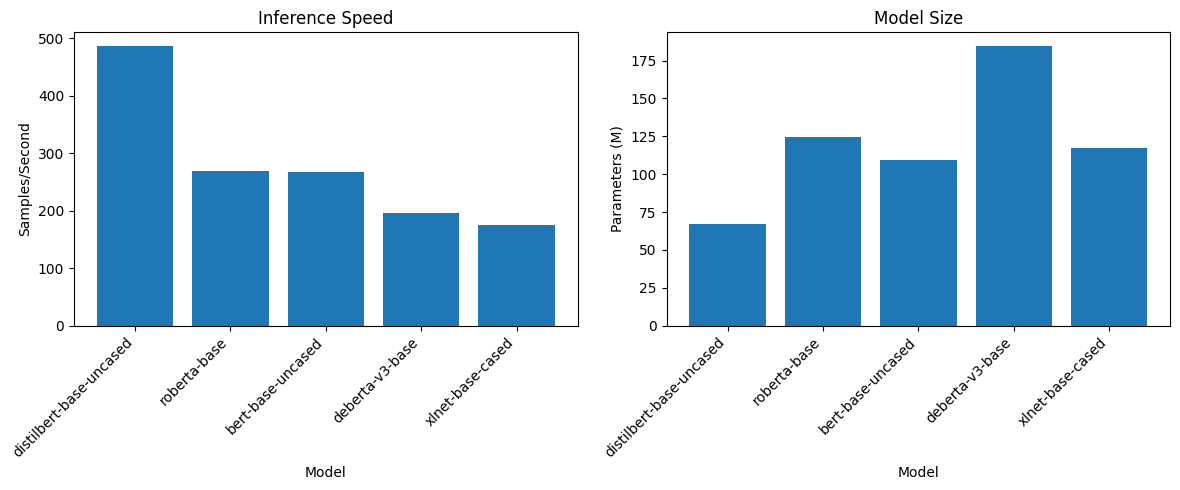

In [ ]:
# Efficiency analysis
efficiency_results = analyze_efficiency(
    models_to_compare,
    data_3class,
    num_classes=3,
    batch_size=BATCH_SIZE
)

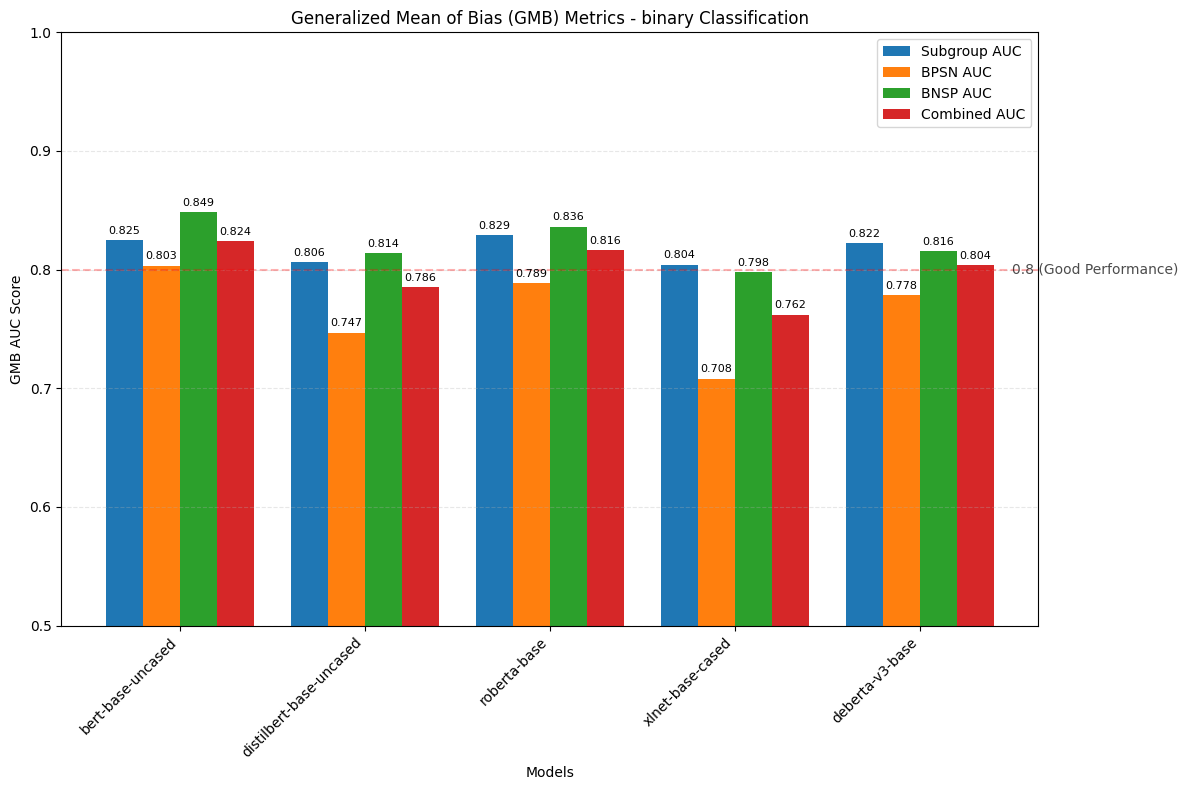

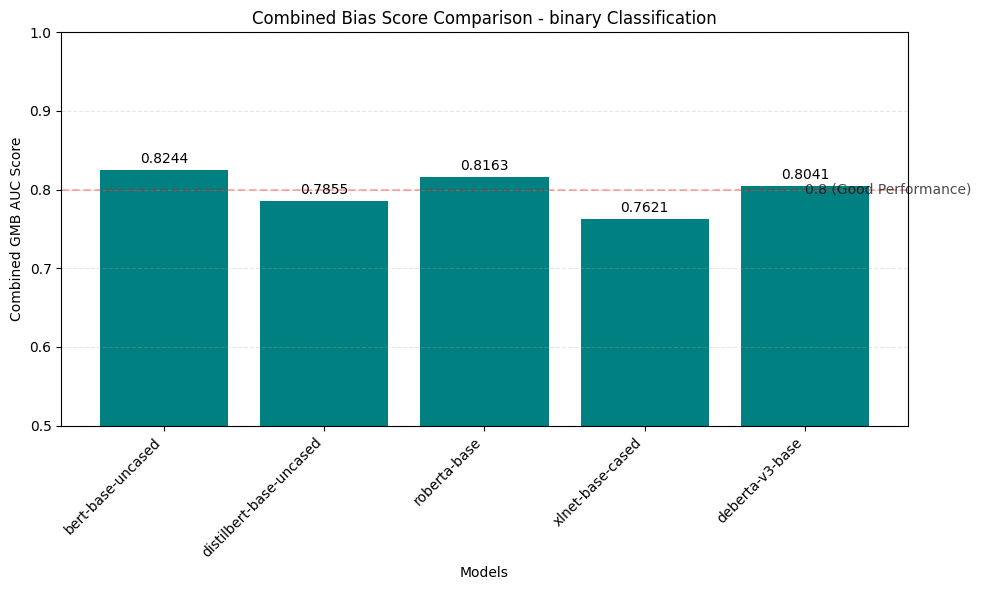

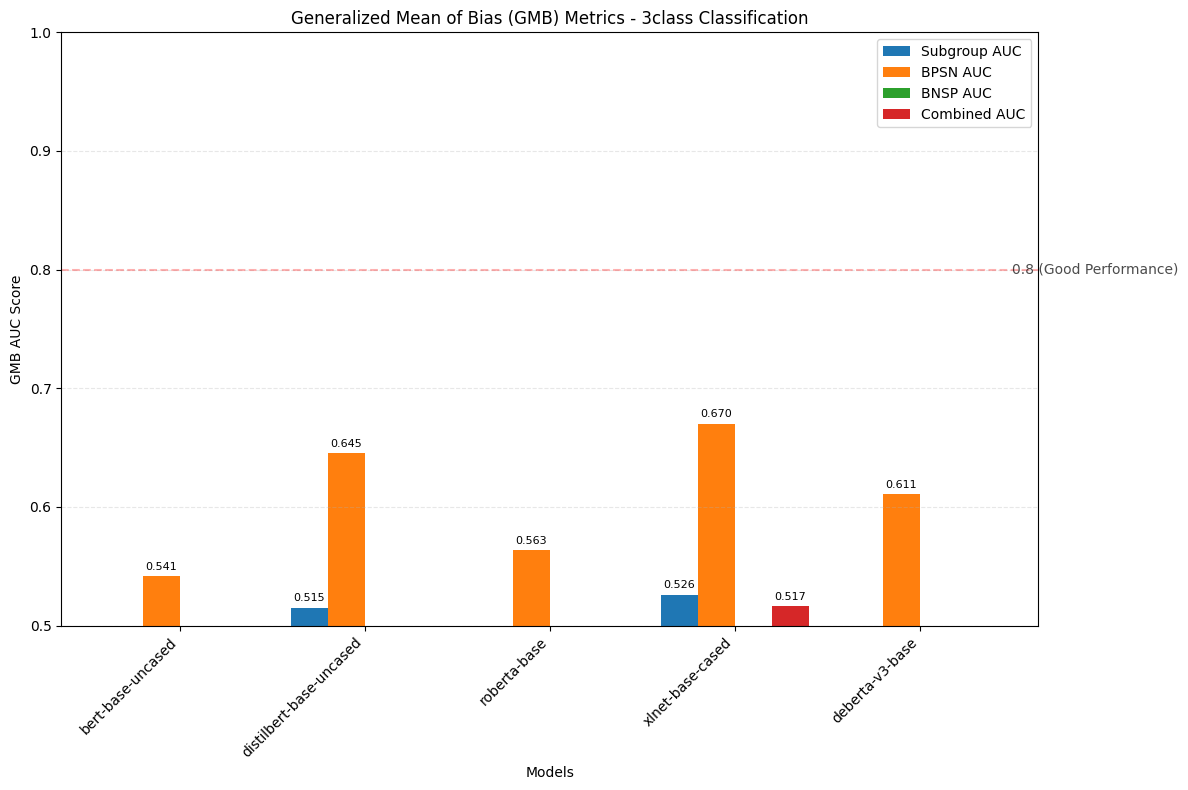

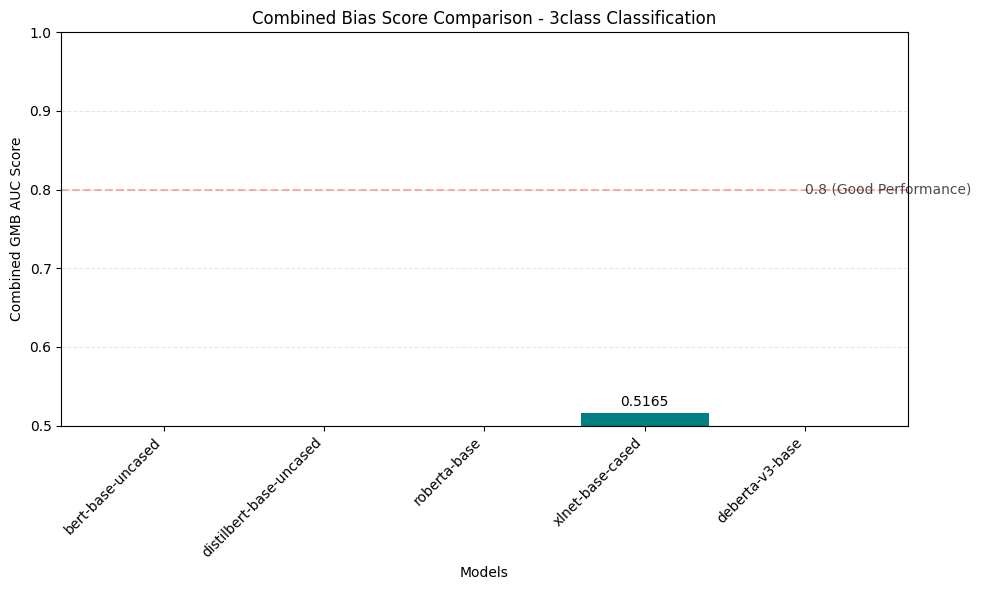

In [ ]:
# Plot GMB metrics
plot_gmb_metrics(comparison_results, task_type='binary')
plot_gmb_metrics(comparison_results, task_type='3class')

In [ ]:
# Generate conclusions
generate_conclusions(summary_table, efficiency_results)


=== FINAL CONCLUSIONS ===

Best model for binary classification:
bert-base-uncased: F1 Score = 0.7865, Accuracy = 0.7941

Best model for 3-class classification:
deberta-v3-base: F1 Score = 0.7033, Accuracy = 0.7155

Most efficient model: distilbert-base-uncased (486.37 samples/second)

Best balance of performance and efficiency:
distilbert-base-uncased on binary task
F1 Score: 0.7732
Inference Speed: 486.37 samples/second
Model Size: 66.96 million parameters

Recommendations:
1. For production environments where speed is critical, consider using a distilled model
2. For applications requiring high accuracy, especially in detecting hate speech, use the best performing model
3. For a balance of performance and efficiency, consider the model with the best balanced score
4. Further research should focus on reducing bias across target groups, as performance varies significantly


In [ ]:
# Save results
save_results(comparison_results, summary_table, efficiency_results)

print("\n=== Project completed successfully ===")

All results saved to the 'results' directory

=== Project completed successfully ===
